# Investigating the Properties of Central Proteins in an Interaction Network
By: Paul Kolbeck

Proteins are large molecules inside of organisms that fulfill a huge variety of functions within organisms. All of biological life hinges on the functions of proteins within organisms. From viruses to whales and everything in between, living beings are basically a collection of proteins that, through complex interactions and mechanisms, ensure the continuation of their own existence. As proteins are an underlying part of all biological processes, understanding proteins and their interactions is an important portion research in biology. 

Proteins are created when a ribosome (a type of protein complex) takes in a gene sequence in the from of a strand of messenger RNA (mRNA), which was transcripted from the DNA in the nucleus of the cell, and starts an amino acid chain. Amino acids are the building blocks of proteins, and are small organic compounds that have binding sites on them that allow them to be bound together in a chain. As the ribosome travels along the mRNA strand, it encounters a sequence of triplets of bases, known as codons. Each codon corresponds to an amino acid, which the ribosome then takes from the surrounding supply and attaches to the budding amino acid chain in the order in which the codons appear. Thus, the mRNA strand is used to build a new sequence of amino acids. This sequence of amino acids then folds into a 3d shape, which then has complex properties based on the sequence of amino acids and how it folded. 

Not only are the proteins themselves complex, but they exist within a sea of other proteins with which they may interact, giving rise to a network of interactions which further infuence the functionality of proteins. As the environments change, so does the function of a protein, so a protein that is a part of one set of interactions in a liver that allow the liver to grow back, may be part of a different set of interactions in skeletal muscle that allow the muscle to contract. Mapping these interactions is thus another integral part in understanding the biological processes in an organism.

In this tutorial, our goal is to investigate possible relationships between several protein characteristics, particularly their role in an interaction network and their structure. For example, one might predict that the number of pathways a protein is a part of may correlate to the number of active sites on a protein, which further correlates with the mass (i.e. size). TODO

## Tools
For this analysis, we use Python 3, along with external packages numpy, pandas, matplotlib, networkx, and statsmodel. TODO

In [457]:
# imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import re
import requests
from bs4 import BeautifulSoup
import statsmodels.api as sm
import io
import time
import warnings
warnings.filterwarnings("ignore")

## Gathering and Cleaning Data
For this tutorial, we chose to use the interaction network data provided by [Innatedb](https://www.innatedb.com/). Innatedb is a database of genes, interactions, and signaling pathways related to the innate immune response of human beings. This was chosen so as to provide a sample of the protein interaction network in the human body with a fleshed out interaction network. As this is a biased sample of the population of all proteins in the human body, results derived from the analysis will only definitively apply to this subset of data, but may inform further investigation in other portions of the human protein interaction network. 

### Acquiring the Innatedb Data
The InnateDB database is only on the order of a hundred Megabytes, so downloading and importing the entire database was taken as the easiest and cleanest way to work with the database. The data from Innatedb was downloaded as a gz zipped file, extracted, and imported using pandas ```read_csv``` method.

In [458]:
# Making a dataframe out of the innate immune system data file, and getting characteristics from it. 
interactionDF = pd.read_csv("./all.mitab/all.mitab", sep = "\t")
print(interactionDF.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418677 entries, 0 to 418676
Data columns (total 42 columns):
 #   Column                               Non-Null Count   Dtype 
---  ------                               --------------   ----- 
 0   #unique_identifier_A                 418677 non-null  object
 1   unique_identifier_B                  418677 non-null  object
 2   alt_identifier_A                     418677 non-null  object
 3   alt_identifier_B                     418677 non-null  object
 4   alias_A                              418677 non-null  object
 5   alias_B                              418677 non-null  object
 6   interaction_detection_method         418677 non-null  object
 7   author                               418677 non-null  object
 8   pmid                                 418677 non-null  object
 9   ncbi_taxid_A                         418677 non-null  object
 10  ncbi_taxid_B                         418677 non-null  object
 11  interaction_type          

We see that we get a 131 MB dataframe, where each entry is an interaction. Each entry features a unique identifier created by InnateDB for proteins A and B, as well as several other identifiers. First, we'd like to check that we have a network. To do this, we are going to make a graph out of the first 2000 entries in the dataframe, as the function that draw the graph from matplotlib and networkx can't handle a graph with 400,000+ edges. 

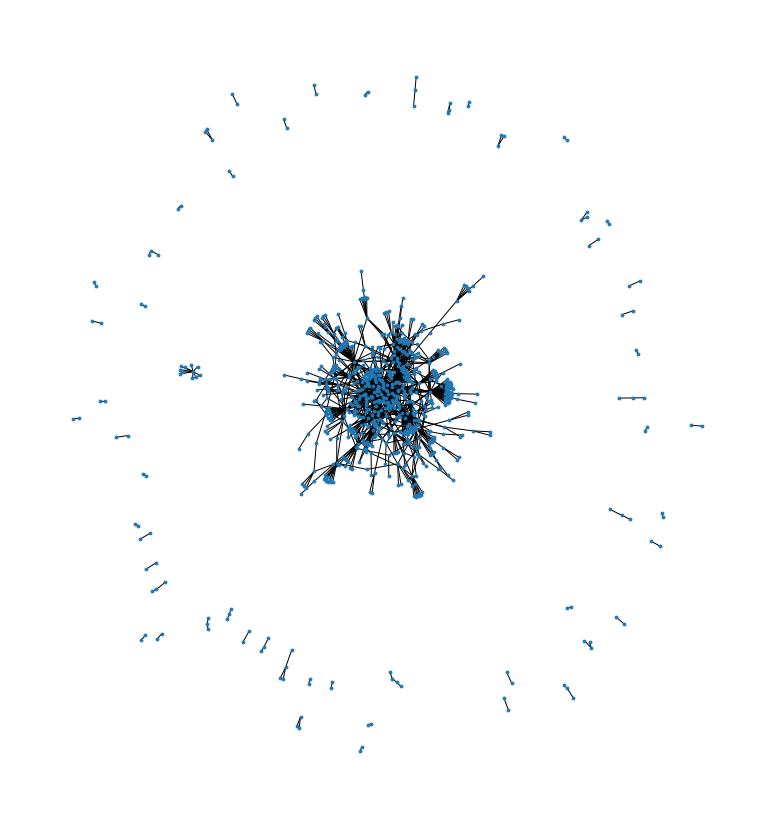

In [460]:
# Taking a look at the network
edgeList = interactionDF[["#unique_identifier_A", "unique_identifier_B"]]
# removing self interaction edges, to reduce clutter
edgeListNoSelf = edgeList[edgeList["#unique_identifier_A"] != edgeList["unique_identifier_B"]]
G = nx.Graph(list(np.array(edgeListNoSelf.head(2000))))
plt.figure(figsize = [30,15])
subax1 = plt.subplot(121)
nx.draw(G, node_size = 8)
plt.show()

Looking at the graph, we can see that there is one main component with a majority of the proteins, and several isolated components. These isolated components may be connected to the main component if we were to include the rest of the edges, but checking using the method of graphing is unreasonable. However, we can take a closer look at the main component, isolating it using networkx's ```connected_components``` algorithm. We change the node color to green and the edge color to red for better contrast.

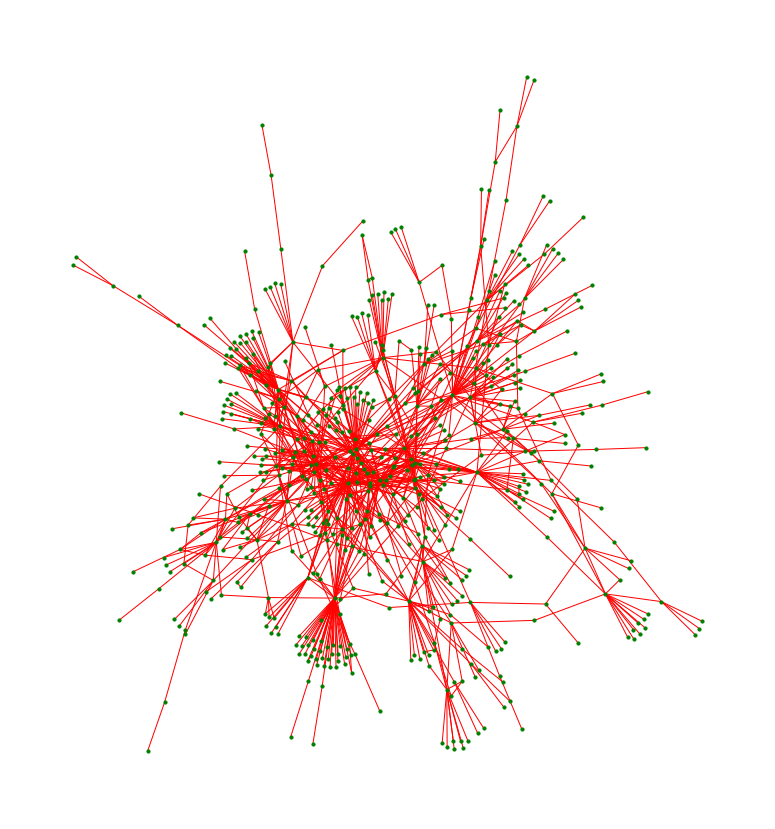

In [463]:
# getting the largest component
S = [G.subgraph(c).copy() for c in nx.connected_components(G)]
Sl = max(S, key=len)
plt.figure(figsize = [30,15])
subax1 = plt.subplot(121)
nx.draw(Sl, node_size = 10, node_color = "green", edge_color = "red")
plt.show()

Just from looking at this graph, we see that we have a variety of positions in the graph - measures of centrality should be varied. We can see that there are some nodes from which there are several edges (i.e. they have a high degree), while there are other nodes that only have one edge. Of course, this is only a component of whole graph, but it suggests that we should expect variance. 
## Getting More Protein Characteristics - Uniprot Database
We have confirmed that we have a network of protein interactions, which means that we have a means of getting measures of centrality for our proteins. However, we would like to compare these measures of centrality to other characteristics of the proteins, and the InnateDB database does not have any characteristics on the proteins themselves. However, the dataframe does supply additional IDs for the proteins, which can be used to query other databases for more information on the proteins. We chose to use the [Uniprot](https://www.uniprot.org/) database for our information on the proteins. The uniprot IDs are listed under the "alias_(A,B)" columns in the InnateDB data, along with a few other IDs. To acquire the Uniprot ID, we use a regular expression. Note that the "alias_(A,B)" actually contains both the Uniprot ID and the Uniprot Entry Name, so we add the '^_' to our regular expression to ensure we match on the ID. 

In [465]:
# Defining function to get the uniprotkb protein id, if it exists. 
def getUniprotkb(str):
    r = re.search("uniprotkb:([^_|]+)[|]", str + "|")
    if r:
        return r.group(1)
    else:
        return "NONE"

# get mapping from innatedb unique identifier to uniprot ID
aProts = (interactionDF["#unique_identifier_A"] + "->" + interactionDF["alias_A"]).unique()
bProts = (interactionDF["unique_identifier_B"] + "->" + interactionDF["alias_B"]).unique()
allProts = np.unique(np.concatenate((aProts, bProts), axis = 0))

protDF  = pd.DataFrame([i.split("->") for i in allProts], columns = ["innateDB_ID","alias"])
protDF["UniprotID"] = protDF["alias"].apply(getUniprotkb)

# Display head, get the number of entries without a uniprotID
print(f"Number of unique innatedb ids: {len(protDF['innateDB_ID'].unique())}")
print(f"{pd.isna(protDF['UniprotID']).sum()} entries are missing a uniprotID out of {protDF.shape[0]}")
display(protDF.head())


Number of unique innatedb ids: 25271
0 entries are missing a uniprotID out of 25271


,innateDB_ID,alias,UniprotID
0,innatedb:IDBG-1,refseq:NP_003131|uniprotkb:Q05066|uniprotkb:SR...,Q05066
1,innatedb:IDBG-100000,uniprotkb:LPAR3_HUMAN|refseq:NP_036284|uniprot...,Q9UBY5
2,innatedb:IDBG-100012,uniprotkb:Q8IWG1|uniprotkb:WDR63_HUMAN|refseq:...,Q8IWG1
3,innatedb:IDBG-10002,refseq:NP_056518|uniprotkb:Q9Y3A4|uniprotkb:RR...,Q9Y3A4
4,innatedb:IDBG-100021,uniprotkb:MCLN3_HUMAN|uniprotkb:Q8TDD5|refseq:...,Q8TDD5


We have a Uniprot ID for every InnateDB ID! This means we don't have to handle any missing values yet. 
### Querying
Now we need to get the protein data from the Uniprot database. Uniprot is popular enough to luckily have an extensive API (TODO), which we take advantage of to query their database for information each protein. There is an upper limit on the number of individual ids that can be queried at the same time, so we divide the list of 25000+ IDs into blocks of length 100. The API also specifies that queries can be limited to certain columns, so we choose a set of columns relevant to our investigation. We chose the id again, the entry name, the organism (to confirm this is a human protein), the mass, the length, the tissue specificity, the disease involvement, the subcellular location, the gene ontology, the domains, the family and the domain extent. 

In [219]:
# breaking the queries into blocks
def makeQueryList(n, ids):
    numBlocks = int((len(ids)/n + 1) - len(ids)/n % 1)
    queryList = []
    for i in range(numBlocks - 1):
        entry = "id:" + ids[i*n]
        for j in range(n-1):
            entry = entry + "+OR+id:" + ids[i*n + 1 + j]
        queryList.append(entry)
    entry = ids[(numBlocks-1)*n]
    for j in range(len(ids) - (numBlocks-1)*n - 1):
        entry = entry + "+OR+" + ids[(numBlocks-1)*n + 1 + j]
    return queryList

proteinQueryList = makeQueryList(100, np.array(protDF[~pd.isna(protDF['UniprotID'])]['UniprotID']))
columns = "columns=id,entry name,organism,mass,length,comment(TISSUE SPECIFICITY),comment(DISEASE),comment(SUBCELLULAR LOCATION),go,comment(DOMAIN),families,feature(DOMAIN EXTENT)"
fmt = "format=tab"

In [227]:
# querying the database for information on the proteins
colQuery = requests.get("https://www.uniprot.org/uniprot/?query=" + protDF[~pd.isna(protDF['UniprotID'])]['UniprotID'][0] + "&" + columns + "&" + fmt)
temp = pd.read_csv(io.StringIO(colQuery.text), sep = "\t")
uniprotDF = pd.DataFrame(columns = temp.columns)
print("Progress\n" + "_"*100)
for i in range(len(proteinQueryList)):
    # make request
    r = requests.get("https://www.uniprot.org/uniprot/?query=" + proteinQueryList[i] + "&" + columns + "&" + fmt)
    temp = pd.read_csv(io.StringIO(r.text), sep = "\t")
    uniprotDF = uniprotDF.merge(temp, how = "outer")
    if i/len(proteinQueryList) % .01 < (i-1)/len(proteinQueryList) % .01: print("=", end = "")
    time.sleep(1)

Progress
____________________________________________________________________________________________________

In [466]:
print(uniprotDF.info())
display(uniprotDF.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23655 entries, 0 to 23654
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Entry                      23655 non-null  object 
 1   Entry name                 23655 non-null  object 
 2   Organism                   23617 non-null  object 
 3   Mass                       23617 non-null  object 
 4   Length                     23617 non-null  float64
 5   Tissue specificity         12509 non-null  object 
 6   Involvement in disease     4452 non-null   object 
 7   Subcellular location [CC]  20868 non-null  object 
 8   Gene ontology (GO)         23253 non-null  object 
 9   Domain [CC]                5417 non-null   object 
 10  Protein families           17655 non-null  object 
 11  Domain [FT]                10999 non-null  object 
dtypes: float64(1), object(11)
memory usage: 2.3+ MB
None


,Entry,Entry name,Organism,Mass,Length,Tissue specificity,Involvement in disease,Subcellular location [CC],Gene ontology (GO),Domain [CC],Protein families,Domain [FT]
0,P19320,VCAM1_HUMAN,Homo sapiens (Human),"81,276",739.0,TISSUE SPECIFICITY: Expressed on inflamed vasc...,NaN,SUBCELLULAR LOCATION: Membrane; Single-pass ty...,alpha9-beta1 integrin-vascular cell adhesion m...,DOMAIN: Either the first or the fourth Ig-like...,NaN,"DOMAIN 25..105; /note=""Ig-like C2-type 1""; DO..."
1,P36543,VATE1_HUMAN,Homo sapiens (Human),"26,145",226.0,TISSUE SPECIFICITY: Kidney; localizes to early...,"DISEASE: Cutis laxa, autosomal recessive, 2C (...",SUBCELLULAR LOCATION: Apical cell membrane {EC...,apical plasma membrane [GO:0016324]; cytosol [...,NaN,V-ATPase E subunit family,NaN
2,Q9UKA9,PTBP2_HUMAN,Homo sapiens (Human),"57,491",531.0,TISSUE SPECIFICITY: Mainly expressed in brain ...,NaN,SUBCELLULAR LOCATION: Nucleus {ECO:0000250|Uni...,growth cone [GO:0030426]; neuronal cell body [...,NaN,NaN,"DOMAIN 59..133; /note=""RRM 1""; /evidence=""EC..."
3,Q96NR8,RDH12_HUMAN,Homo sapiens (Human),"35,094",316.0,"TISSUE SPECIFICITY: Widely expressed, mostly i...",DISEASE: Leber congenital amaurosis 13 (LCA13)...,SUBCELLULAR LOCATION: Endoplasmic reticulum me...,endoplasmic reticulum membrane [GO:0005789]; p...,NaN,Short-chain dehydrogenases/reductases (SDR) fa...,NaN
4,Q52LW3,RHG29_HUMAN,Homo sapiens (Human),"142,064",1261.0,TISSUE SPECIFICITY: Widely expressed. Highly e...,NaN,NaN,cytoplasm [GO:0005737]; cytosol [GO:0005829]; ...,NaN,NaN,"DOMAIN 192..462; /note=""F-BAR""; /evidence=""E..."


We have successfully queried the database! We see that the columns can vary with the number of missing values. Further, by looking at some of the entries, we can already guess that they will be difficult to impossible to extract useful information from, as they are hand-written comments that use varied human language. The tissue specificity column, for example, has entries that read "not expressed in ..." This will be further investigated later in this tutorial. 
### Merging
Now, we would like to combine the InnateDB unique IDS with the Uniprot protein information. To do this, we do a left merge on the "UniprotID" column and the "Entry" column of the InnateDB IDs dataframe and the Uniprot dataframe. 

In [231]:
print(protDF.shape)
print(uniprotDF.shape)
display(protDF.head())
display(uniprotDF.head())

(25271, 3)
(23655, 12)


,innateDB_ID,alias,UniprotID
0,innatedb:IDBG-1,refseq:NP_003131|uniprotkb:Q05066|uniprotkb:SR...,Q05066
1,innatedb:IDBG-100000,uniprotkb:LPAR3_HUMAN|refseq:NP_036284|uniprot...,Q9UBY5
2,innatedb:IDBG-100012,uniprotkb:Q8IWG1|uniprotkb:WDR63_HUMAN|refseq:...,Q8IWG1
3,innatedb:IDBG-10002,refseq:NP_056518|uniprotkb:Q9Y3A4|uniprotkb:RR...,Q9Y3A4
4,innatedb:IDBG-100021,uniprotkb:MCLN3_HUMAN|uniprotkb:Q8TDD5|refseq:...,Q8TDD5


,Entry,Entry name,Organism,Mass,Length,Tissue specificity,Involvement in disease,Subcellular location [CC],Gene ontology (GO),Domain [CC],Protein families,Domain [FT]
0,P19320,VCAM1_HUMAN,Homo sapiens (Human),"81,276",739.0,TISSUE SPECIFICITY: Expressed on inflamed vasc...,NaN,SUBCELLULAR LOCATION: Membrane; Single-pass ty...,alpha9-beta1 integrin-vascular cell adhesion m...,DOMAIN: Either the first or the fourth Ig-like...,NaN,"DOMAIN 25..105; /note=""Ig-like C2-type 1""; DO..."
1,P36543,VATE1_HUMAN,Homo sapiens (Human),"26,145",226.0,TISSUE SPECIFICITY: Kidney; localizes to early...,"DISEASE: Cutis laxa, autosomal recessive, 2C (...",SUBCELLULAR LOCATION: Apical cell membrane {EC...,apical plasma membrane [GO:0016324]; cytosol [...,NaN,V-ATPase E subunit family,NaN
2,Q9UKA9,PTBP2_HUMAN,Homo sapiens (Human),"57,491",531.0,TISSUE SPECIFICITY: Mainly expressed in brain ...,NaN,SUBCELLULAR LOCATION: Nucleus {ECO:0000250|Uni...,growth cone [GO:0030426]; neuronal cell body [...,NaN,NaN,"DOMAIN 59..133; /note=""RRM 1""; /evidence=""EC..."
3,Q96NR8,RDH12_HUMAN,Homo sapiens (Human),"35,094",316.0,"TISSUE SPECIFICITY: Widely expressed, mostly i...",DISEASE: Leber congenital amaurosis 13 (LCA13)...,SUBCELLULAR LOCATION: Endoplasmic reticulum me...,endoplasmic reticulum membrane [GO:0005789]; p...,NaN,Short-chain dehydrogenases/reductases (SDR) fa...,NaN
4,Q52LW3,RHG29_HUMAN,Homo sapiens (Human),"142,064",1261.0,TISSUE SPECIFICITY: Widely expressed. Highly e...,NaN,NaN,cytoplasm [GO:0005737]; cytosol [GO:0005829]; ...,NaN,NaN,"DOMAIN 192..462; /note=""F-BAR""; /evidence=""E..."


In [233]:
# merging the dataframes using the equivalent to SQL's left join, on the uniprot ID.
fullProtDF = protDF.merge(uniprotDF, how = "left", left_on = "UniprotID", right_on = "Entry")
print(fullProtDF.info())
display(fullProtDF.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25271 entries, 0 to 25270
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   innateDB_ID                25271 non-null  object 
 1   alias                      25271 non-null  object 
 2   UniprotID                  25271 non-null  object 
 3   Entry                      23725 non-null  object 
 4   Entry name                 23725 non-null  object 
 5   Organism                   23676 non-null  object 
 6   Mass                       23676 non-null  object 
 7   Length                     23676 non-null  float64
 8   Tissue specificity         12533 non-null  object 
 9   Involvement in disease     4462 non-null   object 
 10  Subcellular location [CC]  20921 non-null  object 
 11  Gene ontology (GO)         23312 non-null  object 
 12  Domain [CC]                5426 non-null   object 
 13  Protein families           17706 non-null  obj

,innateDB_ID,alias,UniprotID,Entry,Entry name,Organism,Mass,Length,Tissue specificity,Involvement in disease,Subcellular location [CC],Gene ontology (GO),Domain [CC],Protein families,Domain [FT]
0,innatedb:IDBG-1,refseq:NP_003131|uniprotkb:Q05066|uniprotkb:SR...,Q05066,Q05066,SRY_HUMAN,Homo sapiens (Human),"23,884",204.0,NaN,"DISEASE: 46,XY sex reversal 1 (SRXY1) [MIM:400...",SUBCELLULAR LOCATION: Nucleus speckle {ECO:000...,chromatin [GO:0000785]; cytoplasm [GO:0005737]...,DOMAIN: DNA binding and bending properties of ...,SRY family,NaN
1,innatedb:IDBG-100000,uniprotkb:LPAR3_HUMAN|refseq:NP_036284|uniprot...,Q9UBY5,Q9UBY5,LPAR3_HUMAN,Homo sapiens (Human),"40,128",353.0,TISSUE SPECIFICITY: Most abundantly expressed ...,NaN,SUBCELLULAR LOCATION: Cell membrane; Multi-pas...,axon [GO:0030424]; cytoplasm [GO:0005737]; int...,NaN,G-protein coupled receptor 1 family,NaN
2,innatedb:IDBG-100012,uniprotkb:Q8IWG1|uniprotkb:WDR63_HUMAN|refseq:...,Q8IWG1,Q8IWG1,DNAI3_HUMAN,Homo sapiens (Human),"102,935",891.0,NaN,DISEASE: Note=A rare heterozygous in-frame DNA...,SUBCELLULAR LOCATION: Cytoplasm {ECO:0000269|P...,axonemal dynein complex [GO:0005858]; cytoplas...,NaN,NaN,NaN
3,innatedb:IDBG-10002,refseq:NP_056518|uniprotkb:Q9Y3A4|uniprotkb:RR...,Q9Y3A4,Q9Y3A4,RRP7A_HUMAN,Homo sapiens (Human),"32,334",280.0,NaN,NaN,NaN,CURI complex [GO:0032545]; cytoplasm [GO:00057...,NaN,RRP7 family,"DOMAIN 61..90; /note=""RRM"""
4,innatedb:IDBG-100021,uniprotkb:MCLN3_HUMAN|uniprotkb:Q8TDD5|refseq:...,Q8TDD5,Q8TDD5,MCLN3_HUMAN,Homo sapiens (Human),"64,248",553.0,NaN,NaN,SUBCELLULAR LOCATION: Cell membrane {ECO:00002...,autophagosome membrane [GO:0000421]; early end...,DOMAIN: The most N-terminal extracellular/lume...,"Transient receptor (TC 1.A.4) family, Polycyst...",NaN


While each InnateDB had listed a UniprotID, not every UniprotID was successfully queried from the Uniprot database. This means some of our InnateDB IDs (the nodes on our network) will not have ay information from Uniprot database. 

### Tidying Data
Now that we have Uniprot data associated with most of the nodes, we would like to make this data usable. Most of the columns are strings that are impossible to use in data analysis. However, some of the columns can be converted into usable information. The "Involvement in disease" entries have [Mendelian Inheritance in Man](https://www.omim.org/) (MIM) Ids, which are IDs of known genetic diseases and can be extracted via a regular expression. The same goes for The "Domain [FT]" column have a set number of descriptors, and the "Gene Ontology (GO)" column, which has [Gene Ontology](http://geneontology.org/) (GO) Ids that describe subcellular locations. The Ids are extracted, put into a list, and into new columns. 

In [318]:
# get the mass as a float
fullProtDF["flMass"] = fullProtDF["Mass"].apply(lambda x: float(str(x).replace(",","")) if ~pd.isna(x) else None)

# process into list of MIM ids
def getMIM(s):
    if pd.isna(s):
        return None
    else:
        return re.findall("\[MIM:(\d+)\]", s)
fullProtDF["MIM"] = fullProtDF["Involvement in disease"].apply(getMIM)

# process domain column into list of IDs
def getDOM(s):
    if pd.isna(s):
        return None
    else:
        return re.findall('/note="([\w\s-]+)"', s)
fullProtDF["Domain_ID"] = fullProtDF["Domain [FT]"].apply(getDOM)

# process to get GO IDs
def getGO(s):
    if pd.isna(s):
        return None
    else:
        return re.findall("\[GO:(\d+)\]", s)
fullProtDF["GO_ID"] = fullProtDF["Gene ontology (GO)"].apply(getGO)

display(fullProtDF.head())


,innateDB_ID,alias,UniprotID,Entry,Entry name,Organism,Mass,Length,Tissue specificity,Involvement in disease,Subcellular location [CC],Gene ontology (GO),Domain [CC],Protein families,Domain [FT],Degree_Centrality,flMass,MIM
0,innatedb:IDBG-1,refseq:NP_003131|uniprotkb:Q05066|uniprotkb:SR...,Q05066,Q05066,SRY_HUMAN,Homo sapiens (Human),"23,884",204.0,NaN,"DISEASE: 46,XY sex reversal 1 (SRXY1) [MIM:400...",SUBCELLULAR LOCATION: Nucleus speckle {ECO:000...,chromatin [GO:0000785]; cytoplasm [GO:0005737]...,DOMAIN: DNA binding and bending properties of ...,SRY family,NaN,0.000953,23884.0,"[400044, 400045]"
1,innatedb:IDBG-100000,uniprotkb:LPAR3_HUMAN|refseq:NP_036284|uniprot...,Q9UBY5,Q9UBY5,LPAR3_HUMAN,Homo sapiens (Human),"40,128",353.0,TISSUE SPECIFICITY: Most abundantly expressed ...,NaN,SUBCELLULAR LOCATION: Cell membrane; Multi-pas...,axon [GO:0030424]; cytoplasm [GO:0005737]; int...,NaN,G-protein coupled receptor 1 family,NaN,0.000079,40128.0,None
2,innatedb:IDBG-100012,uniprotkb:Q8IWG1|uniprotkb:WDR63_HUMAN|refseq:...,Q8IWG1,Q8IWG1,DNAI3_HUMAN,Homo sapiens (Human),"102,935",891.0,NaN,DISEASE: Note=A rare heterozygous in-frame DNA...,SUBCELLULAR LOCATION: Cytoplasm {ECO:0000269|P...,axonemal dynein complex [GO:0005858]; cytoplas...,NaN,NaN,NaN,0.000040,102935.0,[]
3,innatedb:IDBG-10002,refseq:NP_056518|uniprotkb:Q9Y3A4|uniprotkb:RR...,Q9Y3A4,Q9Y3A4,RRP7A_HUMAN,Homo sapiens (Human),"32,334",280.0,NaN,NaN,NaN,CURI complex [GO:0032545]; cytoplasm [GO:00057...,NaN,RRP7 family,"DOMAIN 61..90; /note=""RRM""",0.001033,32334.0,None
4,innatedb:IDBG-100021,uniprotkb:MCLN3_HUMAN|uniprotkb:Q8TDD5|refseq:...,Q8TDD5,Q8TDD5,MCLN3_HUMAN,Homo sapiens (Human),"64,248",553.0,NaN,NaN,SUBCELLULAR LOCATION: Cell membrane {ECO:00002...,autophagosome membrane [GO:0000421]; early end...,DOMAIN: The most N-terminal extracellular/lume...,"Transient receptor (TC 1.A.4) family, Polycyst...",NaN,0.000079,64248.0,None


### Graph Centrality Data
Now that we have useful forms of the protein characteristics, we want to get measures of centrality on the nodes in our network. To do this, we make use of the networkx centrality algorithms. We compute the measure of centrality, and add it as a column to our dataframe. For our measures of centrality, we chose degree, closeness, and eigenvector, as these are some of the most common forms of measuring centrality. Betweenness was left out due to computational limitations.

In [269]:
# getting the graph from the edge list
G = nx.Graph(list(np.array(edgeListNoSelf)))

# adding measures of centrality to the data frame
# degree centrality
a = nx.degree_centrality(G)
fullProtDF["Degree_Centrality"] = fullProtDF["innateDB_ID"].apply(lambda x: a.get(x))


# closeness centrality
a = nx.closeness_centrality(G)
fullProtDF["Closeness_Centrality"] = fullProtDF["innateDB_ID"].apply(lambda x: a.get(x))


# eigenvector centrality
a = nx.eigenvector_centrality(G)
fullProtDF["Eigenvector_Centrality"] = fullProtDF["innateDB_ID"].apply(lambda x: a.get(x))

In [361]:
display(fullProtDF.head())

,innateDB_ID,alias,UniprotID,Entry,Entry name,Organism,Mass,Length,Tissue specificity,Involvement in disease,Subcellular location [CC],Gene ontology (GO),Domain [CC],Protein families,Domain [FT],Degree_Centrality,flMass,MIM,Domain_ID,GO_ID,Closeness_Centrality,Eigenvector_Centrality
0,innatedb:IDBG-1,refseq:NP_003131|uniprotkb:Q05066|uniprotkb:SR...,Q05066,Q05066,SRY_HUMAN,Homo sapiens (Human),"23,884",204.0,NaN,"DISEASE: 46,XY sex reversal 1 (SRXY1) [MIM:400...",SUBCELLULAR LOCATION: Nucleus speckle {ECO:000...,chromatin [GO:0000785]; cytoplasm [GO:0005737]...,DOMAIN: DNA binding and bending properties of ...,SRY family,NaN,0.000953,23884.0,"[400044, 400045]",None,"[0000785, 0005737, 0016607, 0005654, 0005634, ...",0.321910,0.001644
1,innatedb:IDBG-100000,uniprotkb:LPAR3_HUMAN|refseq:NP_036284|uniprot...,Q9UBY5,Q9UBY5,LPAR3_HUMAN,Homo sapiens (Human),"40,128",353.0,TISSUE SPECIFICITY: Most abundantly expressed ...,NaN,SUBCELLULAR LOCATION: Cell membrane; Multi-pas...,axon [GO:0030424]; cytoplasm [GO:0005737]; int...,NaN,G-protein coupled receptor 1 family,NaN,0.000079,40128.0,None,None,"[0030424, 0005737, 0005887, 0005886, 0045202, ...",0.297747,0.000734
2,innatedb:IDBG-100012,uniprotkb:Q8IWG1|uniprotkb:WDR63_HUMAN|refseq:...,Q8IWG1,Q8IWG1,DNAI3_HUMAN,Homo sapiens (Human),"102,935",891.0,NaN,DISEASE: Note=A rare heterozygous in-frame DNA...,SUBCELLULAR LOCATION: Cytoplasm {ECO:0000269|P...,axonemal dynein complex [GO:0005858]; cytoplas...,NaN,NaN,NaN,0.000040,102935.0,[],None,"[0005858, 0005737, 0036156, 0071933, 0045504, ...",0.264544,0.000114
3,innatedb:IDBG-10002,refseq:NP_056518|uniprotkb:Q9Y3A4|uniprotkb:RR...,Q9Y3A4,Q9Y3A4,RRP7A_HUMAN,Homo sapiens (Human),"32,334",280.0,NaN,NaN,NaN,CURI complex [GO:0032545]; cytoplasm [GO:00057...,NaN,RRP7 family,"DOMAIN 61..90; /note=""RRM""",0.001033,32334.0,None,[RRM],"[0032545, 0005737, 0005654, 0034456, 0003723, ...",0.349394,0.006516
4,innatedb:IDBG-100021,uniprotkb:MCLN3_HUMAN|uniprotkb:Q8TDD5|refseq:...,Q8TDD5,Q8TDD5,MCLN3_HUMAN,Homo sapiens (Human),"64,248",553.0,NaN,NaN,SUBCELLULAR LOCATION: Cell membrane {ECO:00002...,autophagosome membrane [GO:0000421]; early end...,DOMAIN: The most N-terminal extracellular/lume...,"Transient receptor (TC 1.A.4) family, Polycyst...",NaN,0.000079,64248.0,None,None,"[0000421, 0031901, 0016021, 0031902, 0005765, ...",0.346118,0.002906


## Linear Regression
Having gotten measures of centrality, we would like to compare the protein characteristics with the measures of centrality via a linear regression. Our list of ids is insufficient for this, as a linear regression does not work with categorical data, to make the data usable, we take the length of the lists, so that we can compare the centrality with the number of domains, genetic diseases, and subcellular locations. 

In [467]:
# Get list of all attributes for each category

# Domains
DomList = []
for i in fullProtDF["Domain_ID"]:
    if i:
        for j in i:
            if not j in DomList:
                DomList.append(j)
print(len(DomList))

# MIM Ids
MIMList = []
for i in fullProtDF["MIM"]:
    if i:
        for j in i:
            if not j in MIMList:
                MIMList.append(j)
print(len(MIMList))

# Gene Ontology Ids
GOList = []
for i in fullProtDF["GO_ID"]:
    if i:
        for j in i:
            if not j in GOList:
                GOList.append(j)
print(len(GOList))

2072
5293
18911


In [468]:
# add list lengths to dataframe
fullProtDF["numMIM"] = fullProtDF["MIM"].apply(lambda x: len(x) if x else None)
fullProtDF["numDOM"] = fullProtDF["Domain_ID"].apply(lambda x: len(x) if x else None)
fullProtDF["numGO"] = fullProtDF["GO_ID"].apply(lambda x: len(x) if x else None)
display(fullProtDF.head())

,innateDB_ID,alias,UniprotID,Entry,Entry name,Organism,Mass,Length,Tissue specificity,Involvement in disease,Subcellular location [CC],Gene ontology (GO),Domain [CC],Protein families,Domain [FT],Degree_Centrality,flMass,MIM,Domain_ID,GO_ID,Closeness_Centrality,Eigenvector_Centrality,numMIM,numDOM,numGO
0,innatedb:IDBG-1,refseq:NP_003131|uniprotkb:Q05066|uniprotkb:SR...,Q05066,Q05066,SRY_HUMAN,Homo sapiens (Human),"23,884",204.0,NaN,"DISEASE: 46,XY sex reversal 1 (SRXY1) [MIM:400...",SUBCELLULAR LOCATION: Nucleus speckle {ECO:000...,chromatin [GO:0000785]; cytoplasm [GO:0005737]...,DOMAIN: DNA binding and bending properties of ...,SRY family,NaN,0.000953,23884.0,"[400044, 400045]",None,"[0000785, 0005737, 0016607, 0005654, 0005634, ...",0.321910,0.001644,2.0,NaN,20.0
1,innatedb:IDBG-100000,uniprotkb:LPAR3_HUMAN|refseq:NP_036284|uniprot...,Q9UBY5,Q9UBY5,LPAR3_HUMAN,Homo sapiens (Human),"40,128",353.0,TISSUE SPECIFICITY: Most abundantly expressed ...,NaN,SUBCELLULAR LOCATION: Cell membrane; Multi-pas...,axon [GO:0030424]; cytoplasm [GO:0005737]; int...,NaN,G-protein coupled receptor 1 family,NaN,0.000079,40128.0,None,None,"[0030424, 0005737, 0005887, 0005886, 0045202, ...",0.297747,0.000734,NaN,NaN,17.0
2,innatedb:IDBG-100012,uniprotkb:Q8IWG1|uniprotkb:WDR63_HUMAN|refseq:...,Q8IWG1,Q8IWG1,DNAI3_HUMAN,Homo sapiens (Human),"102,935",891.0,NaN,DISEASE: Note=A rare heterozygous in-frame DNA...,SUBCELLULAR LOCATION: Cytoplasm {ECO:0000269|P...,axonemal dynein complex [GO:0005858]; cytoplas...,NaN,NaN,NaN,0.000040,102935.0,[],None,"[0005858, 0005737, 0036156, 0071933, 0045504, ...",0.264544,0.000114,NaN,NaN,12.0
3,innatedb:IDBG-10002,refseq:NP_056518|uniprotkb:Q9Y3A4|uniprotkb:RR...,Q9Y3A4,Q9Y3A4,RRP7A_HUMAN,Homo sapiens (Human),"32,334",280.0,NaN,NaN,NaN,CURI complex [GO:0032545]; cytoplasm [GO:00057...,NaN,RRP7 family,"DOMAIN 61..90; /note=""RRM""",0.001033,32334.0,None,[RRM],"[0032545, 0005737, 0005654, 0034456, 0003723, ...",0.349394,0.006516,NaN,1.0,8.0
4,innatedb:IDBG-100021,uniprotkb:MCLN3_HUMAN|uniprotkb:Q8TDD5|refseq:...,Q8TDD5,Q8TDD5,MCLN3_HUMAN,Homo sapiens (Human),"64,248",553.0,NaN,NaN,SUBCELLULAR LOCATION: Cell membrane {ECO:00002...,autophagosome membrane [GO:0000421]; early end...,DOMAIN: The most N-terminal extracellular/lume...,"Transient receptor (TC 1.A.4) family, Polycyst...",NaN,0.000079,64248.0,None,None,"[0000421, 0031901, 0016021, 0031902, 0005765, ...",0.346118,0.002906,NaN,NaN,13.0


Having added the list lengths to our dataframe, we would like to start by doing linear regressions to compare individual parameters. To do this, we make a list of each possible pair of parameters, and then make a list of linear regression solutions for each of them. Finally, we make a histogram showing the distribution in r-squared values, which are indicators of a good fit.

In [469]:
linearRegressList = ["flMass", "Length", 
                     "Degree_Centrality", "Closeness_Centrality", "Eigenvector_Centrality", 
                     "numMIM", "numDOM", "numGO"]
pairs = []
for i in range(len(linearRegressList)-1):
    for j in range(i+1):
        pairs.append((linearRegressList[i+1], linearRegressList[j]))


In [444]:
regressSols = []
for i in pairs:
    a = ~pd.isna(fullProtDF[i[0]])
    b = ~pd.isna(fullProtDF[i[1]])

    x = np.array(fullProtDF[a & b][i[0]]).reshape(-1,1)
    y = np.array(fullProtDF[a & b][i[1]]).reshape(-1,1)
    x = sm.add_constant(x)
    s = sm.OLS(y, x).fit()
    regressSols.append(s)

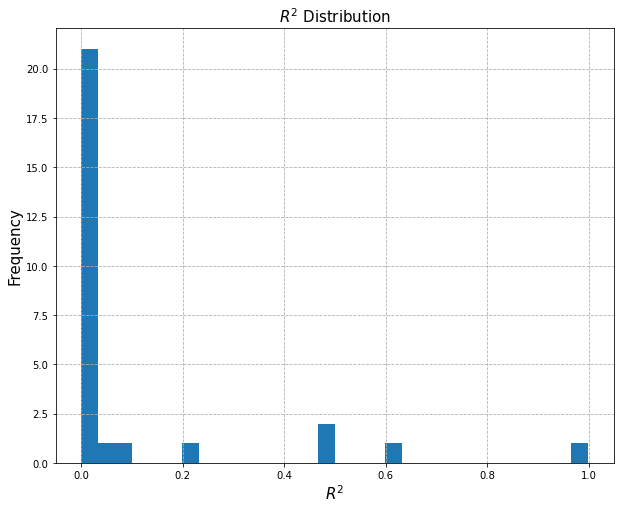

In [471]:
# making a histogram of the r-squared values
fnt = 15
rSq = np.array([i.rsquared for i in regressSols])
plt.figure(figsize = [10,8])
plt.hist(rSq, bins = 30)
plt.grid(True, linestyle = "--")
plt.xlabel(r"$R^2$", fontsize = fnt)
plt.ylabel("Frequency", fontsize = fnt)
plt.title(r"$R^2$ Distribution", fontsize = fnt)
plt.show()

We see that some of the parameters have an r squared of greater than .2. We expect the r squared close to 1 to be the Mass Length relationship, as the longer the protein chain, the heavier it is. We plot the Fits on the data for the parameter pairs with an r squared of greater than .2.

In [472]:
rsqCutoff = .2
nrsq = (rSq > rsqCutoff).sum()
print(f"Number of pairs with an r squared greater than .4: {nrsq}")
# print out the pairs, along with their coefficients and r squared values
for i in range(len(regressSols)):
    if regressSols[i].rsquared > rsqCutoff:
        print(pairs[i])
        

Number of pairs with an r squared greater than .4: 5
('Length', 'flMass')
('Eigenvector_Centrality', 'Degree_Centrality')
('Eigenvector_Centrality', 'Closeness_Centrality')
('numDOM', 'flMass')
('numDOM', 'Length')


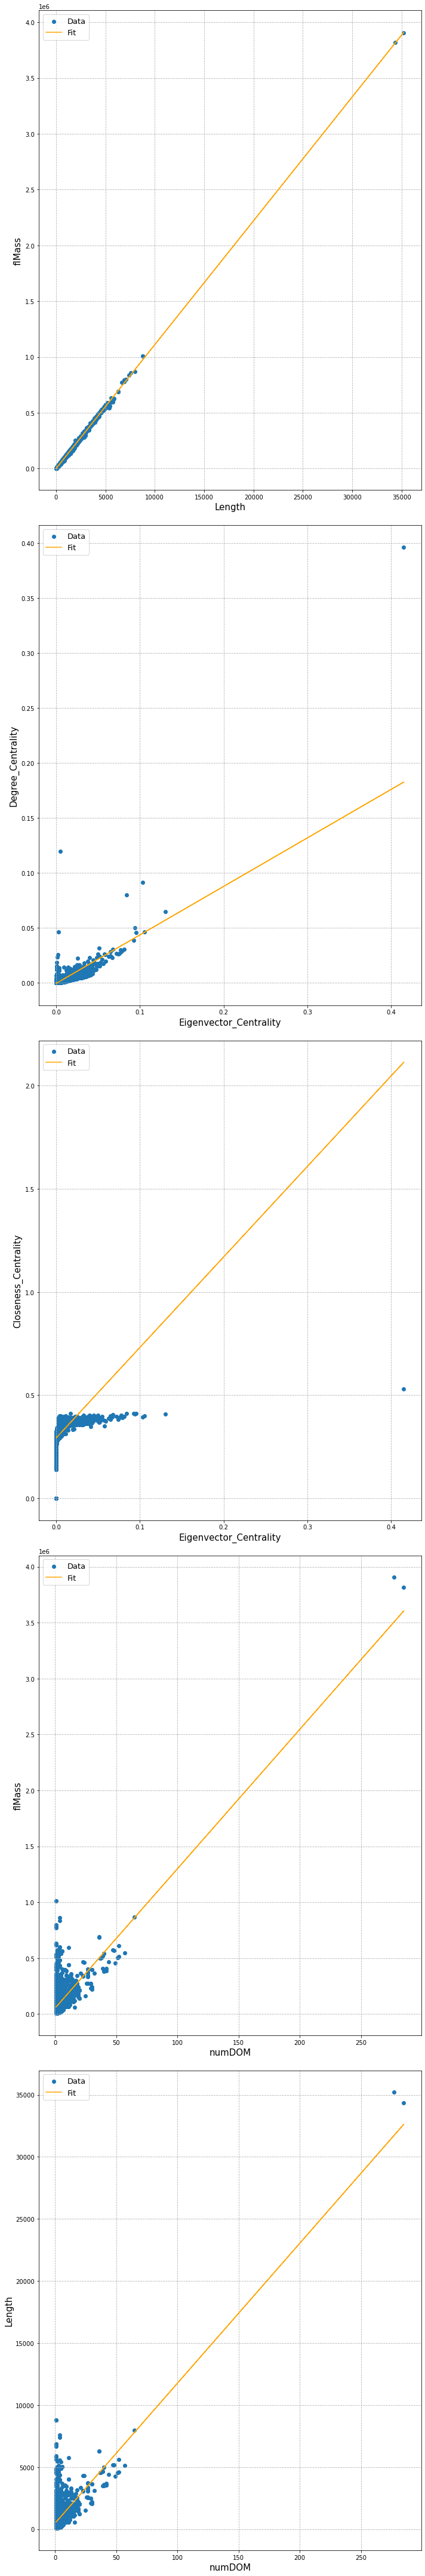

In [473]:
plt.figure(figsize = [10,60])
j = 1
for i in range(len(regressSols)):
    if regressSols[i].rsquared > rsqCutoff:
        plt.subplot(nrsq,1,j)
        j += 1
        a = ~pd.isna(fullProtDF[pairs[i][0]])
        b = ~pd.isna(fullProtDF[pairs[i][1]])

        x = np.array(fullProtDF[a & b][pairs[i][0]]).reshape(-1,1)
        y = np.array(fullProtDF[a & b][pairs[i][1]]).reshape(-1,1)
        plt.scatter(x, y, label = "Data")
        plt.plot(x, regressSols[i].params[1]*x + regressSols[i].params[0], color = "orange", label = "Fit")
        plt.xlabel(pairs[i][0], fontsize = 15)
        plt.ylabel(pairs[i][1], fontsize = 15)
        plt.grid(True, linestyle = "--")
        plt.legend(fontsize = 13)
plt.tight_layout()
plt.show()

It seems that significant correlations presented are lacking in new information. The number of domains is also expected to correspond with the mass/length of the protein, as a larger protein means more subregions in the protein. In addition, the relation between the measures of centrality is also expected, as they do all measure the same idea of a node being central or important in the graph. 
## Conclusion/Future Work
In conclusion, there are no obvious relationships between the location of a protein in an interaction network and the strucutural/locational properties of the protein. In hindsight, that makes a certain amount of sense. A protein may be a part of many pathways, not due to its size or number of domains, but due to how often the function of the protein is necessary. To further investigate this, it would be prudent to observe whether certain pathways or functions correlate with protein centrality. Furthermore, getting details that correspond with the Domain labels, MIM ids, or GO ids from the proteins (i.e. is the centrality for proteins involved in this genetic disease different from proteins involved in that genetic disease). Finally, as proteins have several labels, machine learning may be useful as a predictor of any one label using all the other data. 